In [1]:
%matplotlib inline

In [2]:
import numpy as np
import os
import networkx as nx
import seaborn as sns


from numpy.linalg import eigh
from scipy import sparse as sp
from scipy.sparse import issparse
from matplotlib import pyplot as plt
from collections import defaultdict

from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigs

from helpers import (
    signed_layout, draw_nodes, draw_edges, flatten, get_lcc, signed_laplacian, 
    normalized_laplacian, signed_normalized_laplacian, dict2array, signed_group_conductance,
    conductance_by_sweeping,
    get_borderless_fig, signed_laplacian
)
from motif_adjacency import motif_eef
from algorithms.pagerank import pr_score

In [3]:
graph_name = 'tribe'
path = 'graphs/{}.pkl'.format(graph_name)
fig_rootdir = 'figs/motif_clustering_demo/'

if graph_name == 'tribe':
    # the following are working examples
    query = 8
    alpha = 0.5  # this should be carefully set
#     query = 0
#     alpha = 0.25
elif graph_name == 'cloister':
    query = 2
    alpha = 0.5
#     query = 17
#     alpha = 0.5
elif graph_name == 'congress':
    query = 33
    alpha = 0.25
elif graph_name == 'toy':
    query = 0
    alpha = 0.5
    
FIG_FORMAT = 'pdf'

fig_dir = os.path.join(fig_rootdir, graph_name)
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

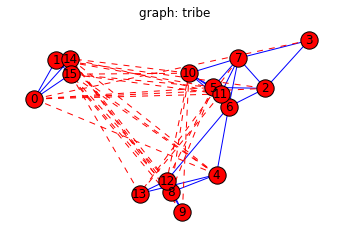

In [4]:
g = nx.read_gpickle(path)

fig, ax = get_borderless_fig()
if graph_name == 'toy':
    pos = g.graph['pos']
else:

    pos = signed_layout(g)
    
draw_nodes(g, pos, ax=ax)
# nx.draw_networkx_nodes(g, pos, node_size=100)
draw_edges(g, pos, ax=ax)
ax.set_title('graph: {}'.format(graph_name))
fig.savefig(fig_dir + '/graph.'+FIG_FORMAT)

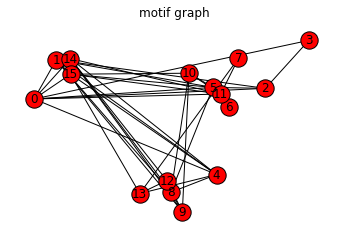

In [5]:
A = nx.adj_matrix(g, weight='sign')
W = motif_eef(A)

g_motif = nx.from_scipy_sparse_matrix(W)

if g_motif.degree(query) == 0:
    raise ValueError('query {} has degree 0 in motif graph'.format(query))
    
fig, ax = get_borderless_fig()
nx.draw_networkx(g_motif, pos=pos, with_labels=True, node_size=300, ax=ax)
ax.set_title('motif graph')
fig.savefig(fig_dir + '/motif-graph.' + FIG_FORMAT)

get node score (local) w.r.t node 8
sweeping
best position 7
community [ 8 12  9 10 14  4  1]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/cloud-user/code/signed/helpers.py:424: RuntimeWarning: invalid value encountered in true_divide
  scores = num_cut / vols


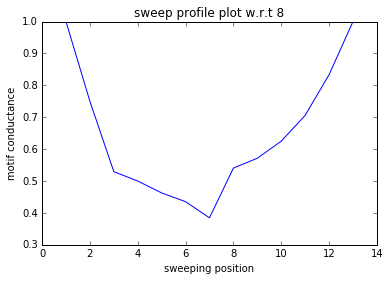

In [6]:
print('get node score (local) w.r.t node {}'.format(query))
z_vect = pr_score(g_motif, query, alpha)    

deg = flatten(W.sum(axis=1))
node_scores = z_vect / deg
node_scores[np.isnan(node_scores)] = 0 # nan due to singleton nodes

n_candidates = (deg > 0).sum()
print('sweeping')

order = np.argsort(node_scores)[::-1]
sweep_scores = conductance_by_sweeping(W, order)

# only consider non-nan scores
sweep_scores = sweep_scores[np.logical_not(np.isnan(sweep_scores))]
sweep_positions = np.arange(1, len(sweep_scores)+1)

    
fig, ax = plt.subplots(1, 1)
ax.plot(sweep_positions, sweep_scores)
ax.set_title('sweep profile plot w.r.t {}'.format(query))
ax.set_xlabel('sweeping position')
ax.set_ylabel('motif conductance')

# get the best community
best_pos = np.argmin(sweep_scores)
comm = order[:best_pos+1]
print('best position', best_pos+1)

# map back the lcc nodes to g
print('community', comm)
fig.savefig(fig_dir + '/sweep-profile-plot.' + FIG_FORMAT)

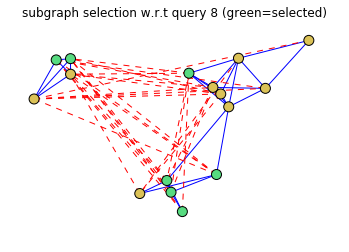

In [7]:
pal = sns.color_palette('hls', 8)
# sns.palplot(pal)

node_color = np.zeros((g.number_of_nodes(), 3))
for i in np.arange(g.number_of_nodes()):
    if i in comm:
        node_color[i] = pal[3]
    else:
        node_color[i] = pal[1]
    
    
fig, ax = get_borderless_fig()    
nx.draw_networkx_nodes(g, pos, node_color=node_color, node_size=100, ax=ax)
draw_edges(g, pos, ax=ax)
ax.set_title('subgraph selection w.r.t query {} (green=selected)'.format(query))
fig.savefig(fig_dir + '/subgraph-selection.' + FIG_FORMAT)

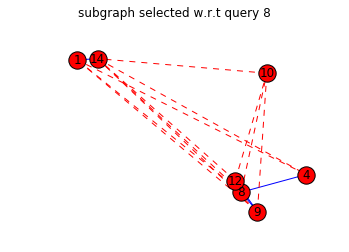

In [8]:
subg = g.subgraph(comm)
mapping = {n: i for i, n in enumerate(comm)}
subg = nx.relabel_nodes(subg, mapping=mapping)
subg_pos = {mapping[n]: pos[n] for n in comm}

# subg = nx.convert_node_labels_to_integers(subg)
# subg_pos = signed_layout(subg)

# draw_nodes(subg, subg_pos)
fig, ax = get_borderless_fig()    
nx.draw_networkx_nodes(subg, subg_pos, node_size=300)
nx.draw_networkx_labels(subg, subg_pos, labels={mapping[n]: n for n in comm})
draw_edges(subg, subg_pos)
ax.set_title('subgraph selected w.r.t query {}'.format(query))
fig.savefig(fig_dir + '/subgraph-selected.' + FIG_FORMAT)

In [9]:
L_subg = signed_normalized_laplacian(nx.adj_matrix(subg, weight='sign'))
# L_subg = signed_laplacian(subg)

0.0625
0.0625
0.125
0.25
best k 2


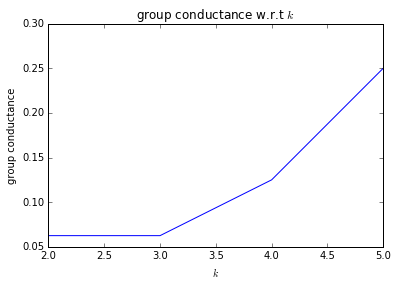

In [10]:
ks = [2, 3, 4, 5]
# ks = [3]

eig_vals, eig_vects = eigs(L_subg.asfptype(), k=max(ks), which='SM')
eig_vects = eig_vects[:, np.argsort(eig_vals)]  # sort them by eigen values
eig_vects = np.real(eig_vects)

avg_phi_list = []
for k in ks:
    embedding = eig_vects[:, :k-1]  # top-k eigen vectors
    kmeans = KMeans(n_clusters=k, random_state=0).fit(embedding)
    labels = kmeans.labels_
    groups = defaultdict(list)    
    for i, l in enumerate(labels):
        groups[l].append(i)
    avg_phi_list.append(signed_group_conductance(subg, groups.values()))
best_k = ks[np.argmin(avg_phi_list)]    
for phi in avg_phi_list:
    print(phi)
print('best k', best_k)

fig, ax = plt.subplots(1, 1)
ax.plot(ks, avg_phi_list)
ax.set_title('group conductance w.r.t $k$')
ax.set_xlabel('$k$')
ax.set_ylabel('group conductance')
fig.savefig(fig_dir + '/group-conductance-sweep.' + FIG_FORMAT)

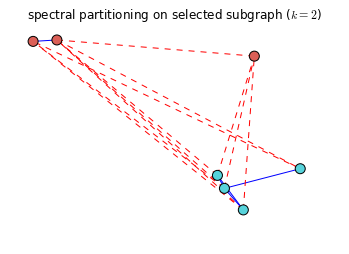

In [11]:
pal = sns.color_palette('hls', best_k)
embedding = eig_vects[:, :best_k-1]  # top-(k-1) eigen vectors
# embedding = eig_vects[:, [True, False, True]]  # top-(k-1) eigen vectors
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(embedding)
node_color = np.zeros((subg.number_of_nodes(), 3))
for i in np.arange(subg.number_of_nodes()):
    node_color[i] = pal[kmeans.labels_[i]]

fig, ax = get_borderless_fig()    
nx.draw_networkx_nodes(subg, subg_pos, node_size=100, node_color=node_color, ax=ax)
draw_edges(subg, subg_pos, ax=ax)
ax.set_title('spectral partitioning on selected subgraph ($k={}$)'.format(best_k))

fig.savefig(fig_dir + '/partitioning.' + FIG_FORMAT)